In [1]:
import re
from time import time

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from catboost import CatBoostClassifier
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, \
                         Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset, DatasetDict
import evaluate
from sentence_transformers import SentenceTransformer
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

/Users/anastasianikitina/PycharmProjects/service-classification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [4]:
df = pd.read_json('data/Sarcasm_Headlines_Dataset_v2.json', lines=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [5]:
df.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


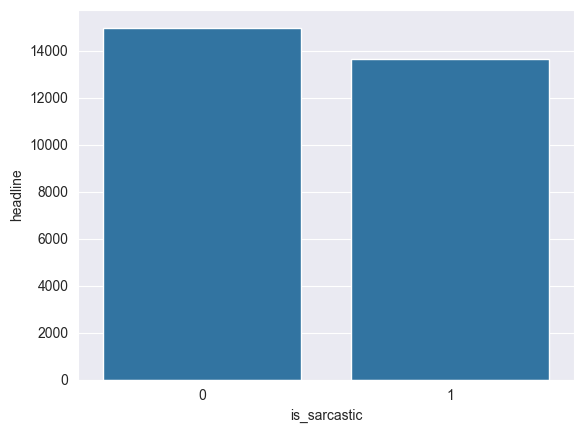

In [6]:
sns.barplot(df.groupby('is_sarcastic').agg('count')['headline']);

In [7]:
df.headline.str.len().describe()

count    28619.000000
mean        62.308571
std         20.726483
min          7.000000
25%         49.000000
50%         62.000000
75%         75.000000
max        926.000000
Name: headline, dtype: float64

In [8]:
df=df.drop(df[df['headline'].duplicated()].index,axis=0)
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28503 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28503 non-null  int64 
 1   headline      28503 non-null  object
 2   article_link  28503 non-null  object
dtypes: int64(1), object(2)
memory usage: 890.7+ KB


# Data Preprocessing

In [9]:
def clean_text(text):
    text = re.sub('[^a-zA-Z ]', ' ', text)  # Удаление специальных символов
    text = text.lower()  # Приведение к нижнему регистру
    text = ' '.join(text.split())  # Удаление лишних пробелов
    return text

df['cleaned_headline'] = df['headline'].apply(clean_text)
df

,is_sarcastic,headline,article_link,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem rep totally nails why congress is falling ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word stream...
...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg gat...


In [10]:
clean_df = df[['cleaned_headline', 'is_sarcastic']]
clean_df

,cleaned_headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails why congress is falling ...,0
2,eat your veggies deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word stream...,1
...,...,...
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg gat...,1


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

clean_df['processed'] = df['cleaned_headline'].apply(preprocess)
print(clean_df)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anastasianikitina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasianikitina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        cleaned_headline  is_sarcastic  \
0      thirtysomething scientists unveil doomsday clo...             1   
1      dem rep totally nails why congress is falling ...             0   
2         eat your veggies deliciously different recipes             0   
3      inclement weather prevents liar from getting t...             1   
4      mother comes pretty close to using word stream...             1   
...                                                  ...           ...   
28614       jews to celebrate rosh hashasha or something             1   
28615  internal affairs investigator disappointed con...             1   
28616  the most beautiful acceptance speech this week...             0   
28617  mars probe destroyed by orbiting spielberg gat...             1   
28618                 dad clarifies this not a food stop             1   

                                               processed  
0      thirtysomething scientists unveil doomsday cl

/var/folders/1h/6qfyp7nn31g62hlw2tr2yltm0000gn/T/ipykernel_11317/1990027873.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['processed'] = df['cleaned_headline'].apply(preprocess)


In [12]:
processed_df = clean_df[['processed', 'is_sarcastic']]
processed_df

,processed,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails congress falling short g...,0
2,eat veggies deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word streaming...,1
...,...,...
28614,jews celebrate rosh hashasha something,1
28615,internal affairs investigator disappointed con...,1
28616,beautiful acceptance speech week came queer ko...,0
28617,mars probe destroyed orbiting spielberg gates ...,1


# Modeling
- Logistic Regression
- Naive Bayes
- Random Forest
- XGBoost
- ruBERT

In [13]:
train, test = train_test_split(processed_df, test_size=0.2, random_state=42, stratify=df['is_sarcastic'])

train

,processed,is_sarcastic
1423,gobbler games brutal hunger games parody need see,0
12087,politicians think microphone start getting real,0
427,mike pence training vice presidential debate h...,1
8995,bizarre mars dune pattern looks like message m...,0
26800,dress code cracked,1
...,...,...
25541,single replaceable person company walk get raise,1
11001,fbi warns american dream scam,1
1363,divorce life reconciliation,0
23446,ai weiwei commemorates drowned refugees berlin...,0


In [14]:
X = processed_df['processed']
y = processed_df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape)

(22802,) (5701,)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Обучение моделей
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}
    
    print(f'{name}: Accuracy - {accuracy}, F1 Score - {f1}')

Logistic Regression: Accuracy - 0.7984564111559376, F1 Score - 0.7768498737618955
Naive Bayes: Accuracy - 0.8024907910892826, F1 Score - 0.7790423861852434
Random Forest: Accuracy - 0.7738993159094896, F1 Score - 0.7378482814724425
XGBoost: Accuracy - 0.7332047009296615, F1 Score - 0.6629736317305561


In [16]:
tf_idf_word_vectorizer = TfidfVectorizer(analyzer = "word")
tf_idf_word_vectorizer.fit(X_train)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

# BERT model = The best model

In [17]:
label2id = {
    'Sarcasm': 1,
    'Not sarcasm': 0
}

id2label = {v: k for k, v in label2id.items()}

In [18]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny", 
                                                      cache_dir='lang_model',
                                                      num_labels=2,
                                                      id2label=id2label)

def preprocess_function(examples):
    return tokenizer(examples["processed"], truncation=True, padding=True, max_length=128)

raw_datasets = DatasetDict({
        "train": Dataset.from_pandas(train[['processed', 'is_sarcastic']]),
        "valid": Dataset.from_pandas(test[['processed', 'is_sarcastic']])
    }
)

tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=['__index_level_0__'],
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = tokenized_datasets.rename_column(original_column_name='is_sarcastic', new_column_name='labels')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 5701/5701 [00:00<00:00, 13491.54 examples/s]


In [19]:
from transformers import Trainer, TrainingArguments
   

f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1': f1.compute(predictions=predictions, references=labels, average="micro")["f1"]}

training_args = TrainingArguments(
    output_dir="lang_model/finetuned_bert",
    use_cpu=True,
    learning_rate=3e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    logging_steps=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model()

/var/folders/1h/6qfyp7nn31g62hlw2tr2yltm0000gn/T/ipykernel_11317/3947285395.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.503400,0.473356,0.775829
2,0.396900,0.443568,0.795650
3,0.370400,0.423059,0.805824
4,0.373200,0.429671,0.806525


In [30]:
finetuned_rubert_tiny = BertForSequenceClassification.from_pretrained("lang_model/finetuned_bert", 
                                                                    cache_dir='lang_model',
                                                                    num_labels=2,
                                                                    id2label=id2label).to('cpu')
tokenizer = BertTokenizer.from_pretrained("lang_model/finetuned_bert")

def get_local_sentiment_rubert_tiny(text, tokenizer=tokenizer, model=finetuned_rubert_tiny):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to('cpu')
        logits = model(**inputs).logits  # Получаем логиты
        proba = torch.sigmoid(logits)  # Применяем сигмоиду для получения вероятностей
        return proba.argmax(dim=1).item()  # Возвращаем индекс класса с максимальной вероятностью

print(classification_report(test.is_sarcastic, test.processed.apply(get_local_sentiment_rubert_tiny)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2990
           1       0.80      0.79      0.80      2711

    accuracy                           0.81      5701
   macro avg       0.81      0.81      0.81      5701
weighted avg       0.81      0.81      0.81      5701


In [42]:
finetuned_rubert_tiny.save_pretrained('model')
tokenizer.save_pretrained('model')

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')